## Задание № 4

### Урок 4. Алгоритм построения дерева решений

#### Задание

1. В коде из методички реализуйте один или несколько из критериев останова
(количество листьев, количество используемых признаков, глубина дерева и т.д.). [решение](Задание_1)
2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.
3. (*) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

### Реализация дерева решений

In [154]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [155]:
# Реализуем класс узла

class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [156]:
# И класс терминального узла (листа)

class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

In [157]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity


# Расчет критерия Шеннона

def shannon(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity += p * np.log2(p)

    return (-1) * impurity

In [158]:
# Расчет качества

def quality_gini(left_labels, right_labels, current_gini):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)
# Расчет качества

def quality_shannon(left_labels, right_labels, current_shannon):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_shannon - p * shannon(left_labels) - (1 - p) * shannon(right_labels)

In [159]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [160]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, metric: callable = quality_gini, metric_start: callable = gini):
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = metric_start(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = metric(true_labels, false_labels, current_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [161]:
# Построение дерева с помощью рекурсивной функции


# def build_tree(data, labels, max_depth, n=1, metric: callable):
def build_tree(data, labels, max_depth, n=1, metric: callable = quality_gini, metric_start: callable = gini):
    quality, t, index = find_best_split(data, labels, metric, metric_start)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    # Ограничения по глубине
    if n > max_depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # глубина дерева
    n += 1
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth, n)
    false_branch = build_tree(false_data, false_labels, max_depth, n)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [162]:
def classify_object(obj, node):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [163]:
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

### Работа с данными

In [164]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.75,
    random_state=5)

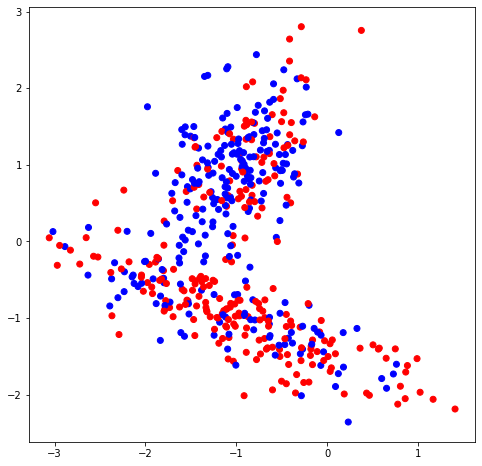

In [165]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8, 8))
plt.scatter(list(map(lambda x: x[0], classification_data)),
            list(map(lambda x: x[1], classification_data)),
            c=classification_labels, cmap=colors)

# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels =\
    model_selection.train_test_split(classification_data,
                                     classification_labels,
                                     test_size=0.3,
                                     random_state=1)

In [166]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth=2)

In [167]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):
    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")


print_tree(my_tree)

Индекс 1
Порог -0.46624201061399206
--> True:
  Индекс 0
  Порог -1.79696585158631
  --> True:
    Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Индекс 0
  Порог -0.9820958539320116
  --> True:
    Прогноз: 1
  --> False:
    Прогноз: 1


In [168]:
# Получим ответы для обучающей выборки
train_answers = predict(train_data, my_tree)

In [169]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [170]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [171]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

65.71428571428571

In [172]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

62.66666666666667

In [186]:
def show_ds(train_data, train_labels, test_data, test_labels, my_tree):
    def get_meshgrid(data, step=.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

    plt.figure(figsize=(16, 7))

    train_answers = predict(train_data, my_tree)

    # И получим ответы для тестовой выборки
    answers = predict(test_data, my_tree)

    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, answers)
    # график обучающей выборки
    plt.subplot(1, 2, 1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto')
    plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap=colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1, 2, 2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors,  shading='auto')
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')


## Задание 1



In [187]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                    classification_labels,
                                                                                    test_size=0.3,
                                                                                    random_state=1)

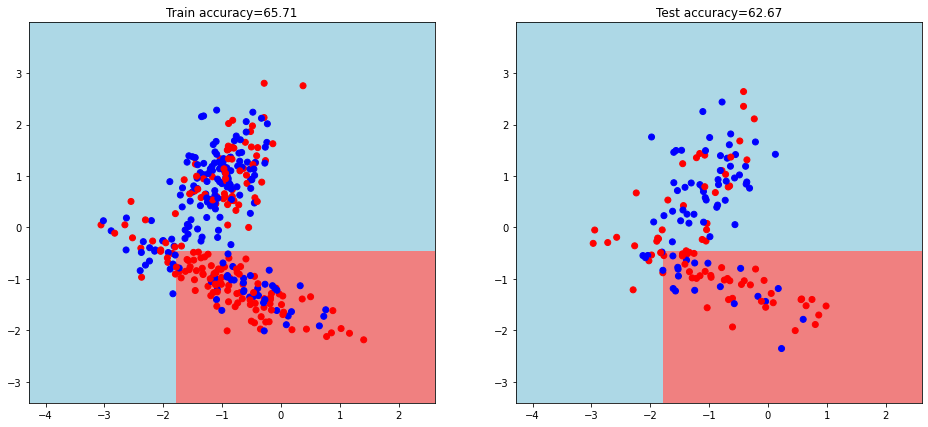

In [188]:
my_tree = build_tree(train_data, train_labels, max_depth=2)
show_ds(train_data, train_labels, test_data, test_labels, my_tree)

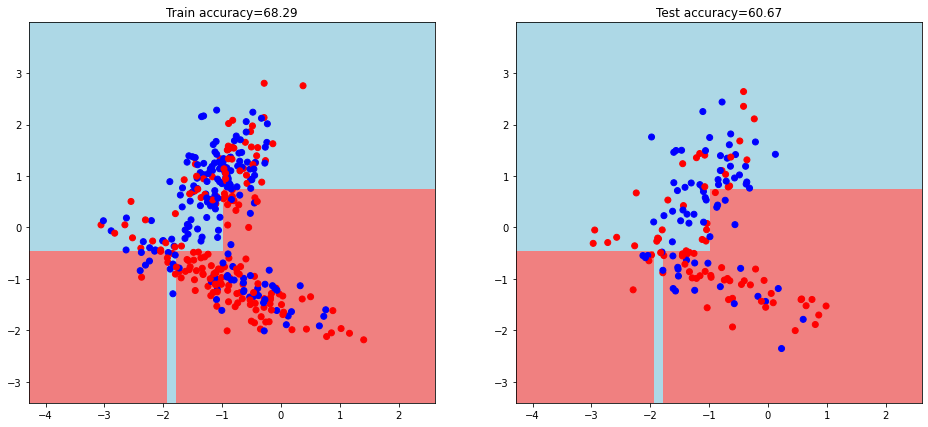

In [189]:
my_tree = build_tree(train_data, train_labels, max_depth=3)
show_ds(train_data, train_labels, test_data, test_labels, my_tree)

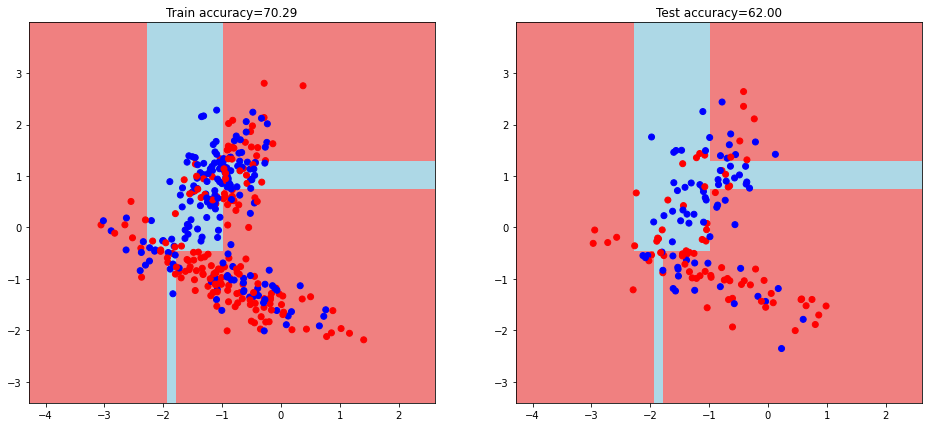

In [190]:
my_tree = build_tree(train_data, train_labels, max_depth=4)
show_ds(train_data, train_labels, test_data, test_labels, my_tree)

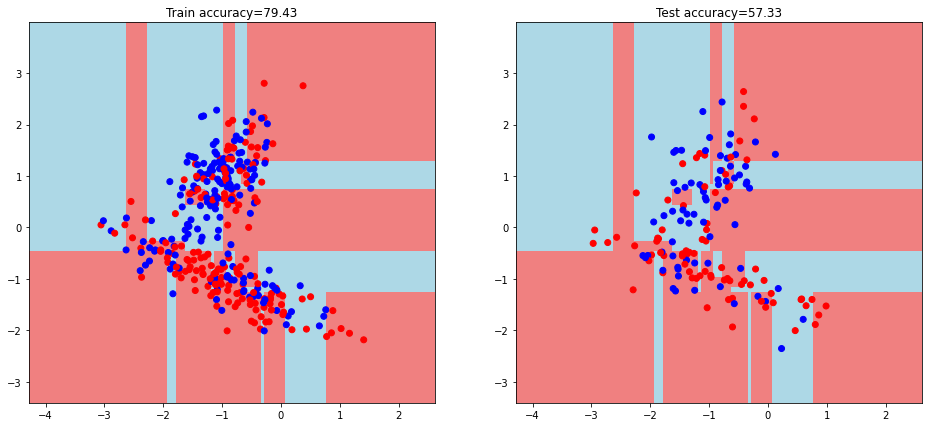

In [191]:
my_tree = build_tree(train_data, train_labels, max_depth=10)
show_ds(train_data, train_labels, test_data, test_labels, my_tree)


## Задание 2

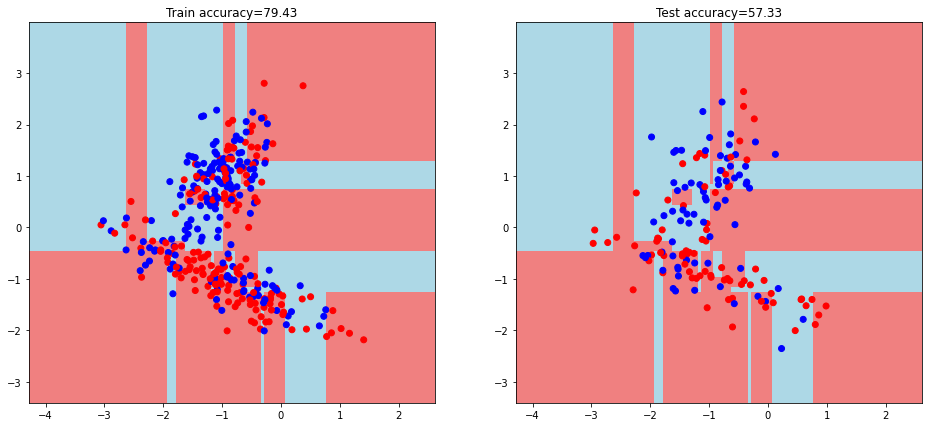

In [194]:
my_tree = build_tree(train_data, train_labels, max_depth=20, metric=quality_gini, metric_start=gini)
show_ds(train_data, train_labels, test_data, test_labels, my_tree)

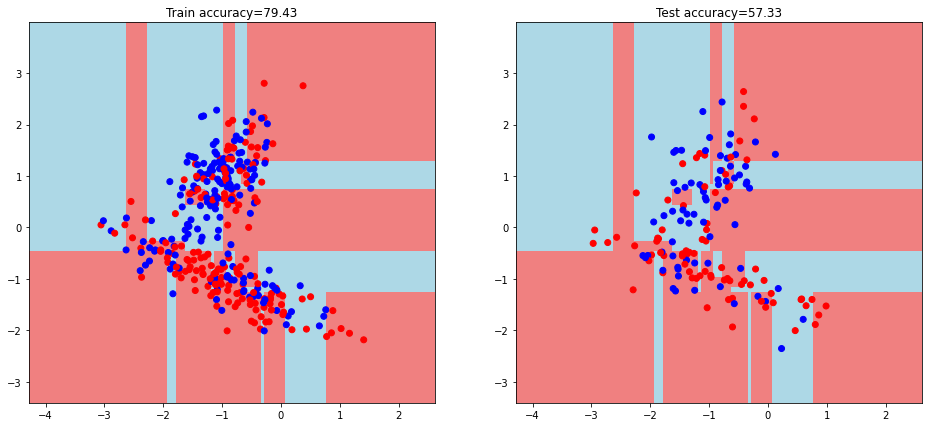

In [195]:
my_tree = build_tree(train_data, train_labels, max_depth=20, metric=quality_shannon, metric_start=shannon)
show_ds(train_data, train_labels, test_data, test_labels, my_tree)



> использование метрик Джини и Шеннона на резульат на малых объемах практически не меняется.
> Поэтому основное внимание должно быть уделено конечным оценкам качества всех модели.  

